In [2]:
# Read in goal_shot_rows.csv

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

import data_prep

pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
def create_input_data_from_csv(path_to_csv):
    df = pd.read_csv(path_to_csv)

    # get list of ilocs of rows where the 'Event' column is 'GOAL or SHOT or MISS'
    goal_shot_rows = df.loc[df['Event'].isin(['GOAL', 'SHOT', 'MISS'])]

    # shift the dataframe by 1 row
    shifted_df = df.shift(1)
    shifted_df.columns = ['prev_' + name for name in df.columns]

    # combine goal_shot_rows with shifted_df, but using rows from goal_shot_rows
    goal_shot_rows = pd.concat([goal_shot_rows, shifted_df.loc[goal_shot_rows.index]], axis=1)

    goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 0]
    goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 5]

    # Create "home_or_away" column based on if "Ev_team" is the same as "Home_Team" or "Away_Team"
    goal_shot_rows['home_or_away'] = goal_shot_rows.apply(lambda x: 'home' if x['Ev_Team'] == x['Home_Team'] else 'away', axis=1)
    
    # check to see if on power play if "home_or_away" is equal to "home" and "Strength" is equal to "5x4" or "home_or_away" is equal to "away" and "Strength" is equal to "4x5"
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "5x4" if (x['home_or_away'] == 'home' and x['Strength'] == '5x4' ) or (x['home_or_away'] == 'away' and x['Strength'] == '4x5') else "5x5", axis=1)

    # similar as above, but for 5x3
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "5x3" if (x['home_or_away'] == 'home' and x['Strength'] == '5x3' ) or (x['home_or_away'] == 'away' and x['Strength'] == '3x5') else x['true_strength'], axis=1)

    # similar as above, but for 6x5
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "6x5" if (x['home_or_away'] == 'home' and x['Strength'] == '6x5' ) or (x['home_or_away'] == 'away' and x['Strength'] == '5x6') else x['true_strength'], axis=1)

    # similar as above, but for 4x3
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "4x3" if (x['home_or_away'] == 'home' and x['Strength'] == '4x3' ) or (x['home_or_away'] == 'away' and x['Strength'] == '3x4') else x['true_strength'], axis=1)

    # similar as above,but for 3x3
    goal_shot_rows['true_strength'] = goal_shot_rows.apply(lambda x: "3x3" if (x['home_or_away'] == 'home' and x['Strength'] == '3x3' ) or (x['home_or_away'] == 'away' and x['Strength'] == '3x3') else x['true_strength'], axis=1)

    # check to see if a shot is on an empty net by checking if home_or_away is equal to "home" and "Away_Goalie" is equal to "None" or home_or_away is equal to "away" and "Home_Goalie" is equal to "None"
    goal_shot_rows['on_empty_net'] = goal_shot_rows.apply(lambda x: 1 if (x['home_or_away'] == 'home' and x['Away_Goalie'] == '') or (x['home_or_away'] == 'away' and x['Home_Goalie'] == '') else 0, axis=1)


    val_input_data = goal_shot_rows[['Event', 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC', 'home_or_away', 'true_strength', 'on_empty_net', 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC']]
    val_result_data = goal_shot_rows['Event']
    val_result_data = val_result_data.apply(lambda x: 1 if x == "GOAL" else 0)

    # Create a new column "is_PS" if prev_Type starts with "PS"
    val_input_data['prev_Type'] = val_input_data['prev_Type'].fillna("")
    val_input_data['is_PS'] = val_input_data['prev_Type'].str.startswith('PS').astype(int)

    # For "prev_Type" column, if "min)" or "maj)", then convert it to just "PENL"
    val_input_data['prev_Type'] = val_input_data['prev_Type'].apply(lambda x: 'PENL' if x.endswith('min)') or x.endswith('maj)') else x)
    
    # For "prev_Event" column, if it start with "PS", then convert it to just "PS"
    # val_input_data['prev_Event'] = val_input_data['prev_Event'].apply(lambda x: 'PS' if x.startswith('PS') else x)
    print(val_input_data['prev_Type'].unique())

    val_input_data = val_input_data.drop(columns=['Event'])

    # Split out the data between numeric values (can carry forward) and categorical values (need to be turned into binary columns)
    val_input_data_numeric = val_input_data[['Seconds_Elapsed', 'xC', 'yC', 'on_empty_net','prev_Seconds_Elapsed', 'prev_xC', 'prev_yC', 'is_PS']]
    val_input_data_categorical = pd.DataFrame()



    for column in ['Period', 'Type', 'true_strength', 'home_or_away']:
        dummy_columns = pd.get_dummies(val_input_data[column])
        val_input_data_categorical = pd.concat([dummy_columns, val_input_data_categorical], axis=1)

    for column in ['prev_Event', 'prev_Strength', 'prev_Type']:
        dummy_columns = pd.get_dummies(val_input_data[column])

        # rename all columns with a prefix of "prev_"
        dummy_columns.columns = ['prev_' + str(col) for col in dummy_columns.columns]
        val_input_data_categorical = pd.concat([val_input_data_categorical, dummy_columns], axis=1)
        
    # change all True/False to 1/0
    val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)

    # combine the two dataframes
    val_input_data_combined = pd.concat([val_input_data_numeric, val_input_data_categorical], axis=1)

    #set val_input_data2 to be all floats
    val_input_data_combined = val_input_data_combined.astype(float)

    print(val_input_data_combined.columns)

    columns = [     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                        '6x5',             'BACKHAND',            'DEFLECTED',
                  'SLAP SHOT',            'SNAP SHOT',               'TIP-IN',
                'WRAP-AROUND',           'WRIST SHOT',                      1,
                            2,                      3,                      4,
                 'prev_BLOCK',             'prev_CHL',             'prev_FAC',
                  'prev_GEND',            'prev_GIVE',            'prev_GOAL',
                   'prev_HIT',            'prev_MISS',            'prev_PENL',
                  'prev_PENL',            'prev_SHOT',            'prev_STOP',
                  'prev_TAKE',            'prev_-1x3',            'prev_-1x5',
                   'prev_0x1',             'prev_0x5',             'prev_3x3',
                   'prev_3x4',             'prev_3x5',             'prev_4x3',
                   'prev_4x4',             'prev_4x5',             'prev_5x0',
                   'prev_5x3',             'prev_5x4',             'prev_5x5',
                   'prev_5x6',             'prev_6x5',                'prev_',
              'prev_BACKHAND',       'prev_DEFLECTED',            'prev_PENL',
                  'prev_PENL',       'prev_SLAP SHOT',       'prev_SNAP SHOT',
                'prev_TIP-IN',     'prev_WRAP-AROUND',      'prev_WRIST SHOT']

    # For each column in input_data_combined, check if it exists in val_input_data_combined, if not add it as all 0s
    for column in columns:
        if column not in val_input_data_combined.columns:
                val_input_data_combined[column] = 0

    for column in val_input_data_combined.columns:
        if column not in columns:
                if column in val_input_data_combined.columns:
                    print(f"Column {column} not in columns")
                    val_input_data_combined = val_input_data_combined.drop(column, axis=1)


    # reduce val_input_data_combined to have the same columns as input_data_combined
    val_input_data_combined = val_input_data_combined[columns]

    # change all NaN numbers to 0
    val_input_data_combined = val_input_data_combined.fillna(0)

    print(val_input_data_combined.shape)


    filepath = '0430_xG_Model_1500K.pt'

    model = nn.Sequential(
        nn.Linear(66, 180),
        nn.ReLU(),
        nn.Linear(180, 60),
        nn.ReLU(),
        nn.Linear(60, 1),
        nn.Sigmoid()
    )


    model.load_state_dict(torch.load('0430_xG_Model_1500K.pt'))
    model.eval()
    model.cpu()
    x = torch.tensor(val_input_data_combined.values, dtype=torch.float32)
    y = torch.tensor(val_result_data.values, dtype=torch.float32)
    result = model(x)

    # add the probability of a goal to val_input_data_combined
    goal_shot_rows['Goal_Probability'] = result.detach().numpy()

    return val_input_data_combined, val_result_data, goal_shot_rows

# Model Evaluation


First Up, single game xG creation


In [7]:
val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20232024.csv")


['' 'WRIST SHOT' 'SNAP SHOT' 'SLAP SHOT' 'TIP-IN' 'PENL' 'BACKHAND'
 'DEFLECTED' 'WRAP-AROUND']


C:\Users\JoshG\AppData\Local\Temp\ipykernel_22828\504239315.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '3x3',                  '4x3',
                        '5x3',                  '5x4',                  '5x5',
                   'BACKHAND',            'DEFLECTED',            'SLAP SHOT',
                  'SNAP SHOT',               'TIP-IN',          'WRAP-AROUND',
                 'WRIST SHOT',                      1,                      2,
                            3,                      4,           'prev_BLOCK',
                   'prev_CHL',          'prev_DELPEN',             'prev_FAC',
                  'prev_GIVE',             'prev_HIT',            'prev_MISS',
                  'prev_PENL',            'prev_SHOT',            'prev_STOP',
                  'prev_TAKE',             'prev_3x3

In [4]:
filepath = '0430_xG_Model_1500K.pt'

model = nn.Sequential(
    nn.Linear(66, 180),
    nn.ReLU(),
    nn.Linear(180, 60),
    nn.ReLU(),
    nn.Linear(60, 1),
    nn.Sigmoid()
)


model.load_state_dict(torch.load('0430_xG_Model_1500K.pt'))
model.eval()
model.cpu()

x = torch.tensor(val_input_data.values, dtype=torch.float32)
y = torch.tensor(val_result_data.values, dtype=torch.float32)



NameError: name 'val_input_data' is not defined

In [132]:
# get the accuracy of the model
y_pred = model(x)

# convert the tensor to a numpy array
y_pred = y_pred.detach().numpy()
y = y.detach().numpy()

In [67]:


print(y_pred)
print(y)

# accuracy = (y_pred.round() == y).float().mean()\
accuracy_results = []

for i in range(len(y_pred)):
    print(f"Prediction: {y_pred[i][0]} Actual: {y[i]}")
    if y_pred[i][0].round() == y[i]:
        accuracy_results.append(1)
    else:
        accuracy_results.append(0)

accuracy = sum(accuracy_results) / len(accuracy_results)
print(f"Accuracy {accuracy}")


[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [1.3511864e-12]
 [6.7808640e-01]
 [2.4697429e-01]]
[0. 0. 0. ... 0. 1. 0.]
Prediction: 0.0 Actual: 0.0
Prediction: 0.0 Actual: 0.0
Prediction: 0.0 Actual: 0.0
Prediction: 0.0 Actual: 0.0
Prediction: 0.0 Actual: 0.0
Prediction: 3.7139655766058084e-36 Actual: 0.0
Prediction: 0.176996648311615 Actual: 0.0
Prediction: 0.0 Actual: 0.0
Prediction: 0.9753722548484802 Actual: 0.0
Prediction: 0.0 Actual: 0.0
Prediction: 1.0 Actual: 1.0
Prediction: 0.0 Actual: 0.0
Prediction: 1.3824208825645565e-32 Actual: 0.0
Prediction: 9.522867827627124e-08 Actual: 0.0
Prediction: 0.019943607971072197 Actual: 0.0
Prediction: 1.5340070547154028e-07 Actual: 0.0
Prediction: 0.0008054245263338089 Actual: 0.0
Prediction: 0.003907309379428625 Actual: 0.0
Prediction: 0.8706992268562317 Actual: 0.0
Prediction: 0.004336368292570114 Actual: 0.0
Prediction: 0.00031322622089646757 Actual: 0.0
Prediction: 0.002051207236945629 Actual: 0.0
Prediction: 0.0 Actual: 0.0


<Axes: xlabel='Type', ylabel='Goal_Probability'>

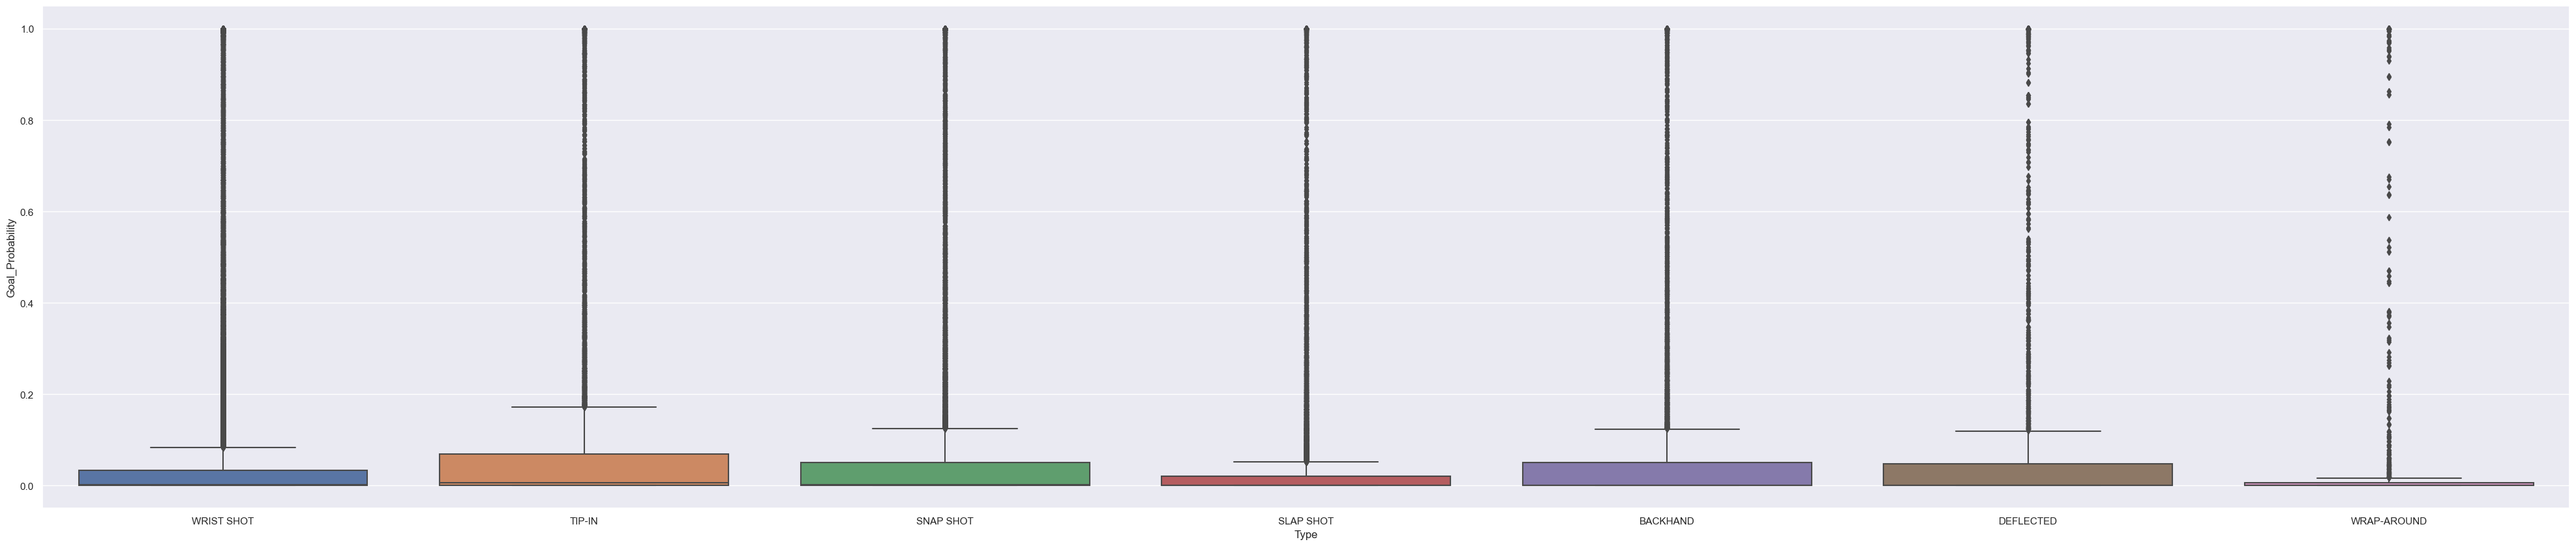

In [141]:
result = model(x)

# add the probability of a goal to val_input_data_combined
original_input['Goal_Probability'] = result.detach().numpy()

# make a boxplot of Goal_Probability vs Type
sns.set_theme(rc={'figure.figsize':(50,10)})
sns.boxplot(x=original_input["Type"], y=original_input["Goal_Probability"])
# sns.scatterplot(x=original_input["Type"], y=original_input["Goal_Probability"])


# Single Game 5v5 evaluation



In [5]:
def single_game_evaluation(original_input, game_id, state = "any"):
    game_rows = original_input[original_input["Game_Id"] == game_id]

    if state != "any":
        game_rows = game_rows[game_rows["Strength"] == state]

    # get first value of Home_Team and Away_Team
    home_team = game_rows["Home_Team"].iloc[0]
    away_team = game_rows["Away_Team"].iloc[0]

    # get all rows where the Ev_Team is the home team
    home_team_rows = game_rows[game_rows["Ev_Team"] == home_team]

    # get all rows where the Ev_Team is the away team
    away_team_rows = game_rows[game_rows["Ev_Team"] == away_team]

    # add a new column "total_xG" to home_team_rows and away_team_rows
    home_team_rows["total_xG"] = home_team_rows["Goal_Probability"].cumsum()
    away_team_rows["total_xG"] = away_team_rows["Goal_Probability"].cumsum()

    # time elapsed is (period - 1) * 1200 + seconds_elapsed
    home_team_rows["Seconds_Elapsed"] = (home_team_rows["Period"] - 1) * 1200 + home_team_rows["Seconds_Elapsed"]
    home_team_rows["Minutes_Elapsed"] = home_team_rows["Seconds_Elapsed"] / 60

    # print home_team_rows to csv
    # home_team_rows.to_csv("home_team_rows.csv")

    # time elapsed is (period - 1) * 1200 + seconds_elapsed
    away_team_rows["Seconds_Elapsed"] = (away_team_rows["Period"] - 1) * 1200 + away_team_rows["Seconds_Elapsed"]
    away_team_rows["Minutes_Elapsed"] = away_team_rows["Seconds_Elapsed"] / 60

    # away_team_rows.to_csv("away_team_rows.csv")

    total_home_xG = home_team_rows["total_xG"].iloc[-1].round(2)
    total_away_xG = away_team_rows["total_xG"].iloc[-1].round(2)

    # combine home_team_rows and away_team_rows into one dataframe
    combined_rows = pd.concat([home_team_rows, away_team_rows])

    home_score = home_team_rows["Home_Score"].iloc[-1]
    away_score = away_team_rows["Away_Score"].iloc[-1]

    return combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score


In [10]:
game_id = 30123

val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_1714030348.csv")






['' 'WRIST SHOT' 'SNAP SHOT' 'SLAP SHOT' 'BACKHAND' 'TIP-IN' 'DEFLECTED']
Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '5x4',                  '5x5',
                   'BACKHAND',            'DEFLECTED',            'SLAP SHOT',
                  'SNAP SHOT',               'TIP-IN',          'WRAP-AROUND',
                 'WRIST SHOT',                      1,                      2,
                            3,           'prev_BLOCK',          'prev_DELPEN',
                   'prev_FAC',            'prev_GIVE',             'prev_HIT',
                  'prev_MISS',            'prev_SHOT',            'prev_TAKE',
                   'prev_4x4',             'prev_4x5',             'prev_5x4',
                   'prev_5x5',                'prev_',   

C:\Users\JoshG\AppData\Local\Temp\ipykernel_22828\2989907643.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


['' 'WRIST SHOT' 'SNAP SHOT' 'SLAP SHOT' 'BACKHAND' 'TIP-IN' 'DEFLECTED']
Index([     'Seconds_Elapsed',                   'xC',                   'yC',
               'on_empty_net', 'prev_Seconds_Elapsed',              'prev_xC',
                    'prev_yC',                'is_PS',                 'away',
                       'home',                  '5x4',                  '5x5',
                   'BACKHAND',            'DEFLECTED',            'SLAP SHOT',
                  'SNAP SHOT',               'TIP-IN',          'WRAP-AROUND',
                 'WRIST SHOT',                      1,                      2,
                            3,           'prev_BLOCK',          'prev_DELPEN',
                   'prev_FAC',            'prev_GIVE',             'prev_HIT',
                  'prev_MISS',            'prev_SHOT',            'prev_TAKE',
                   'prev_4x4',             'prev_4x5',             'prev_5x4',
                   'prev_5x5',                'prev_',   

C:\Users\JoshG\AppData\Local\Temp\ipykernel_22828\2989907643.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)
c:\Users\JoshG\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\JoshG\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'TOR (2.65) vs BOS (2.39)'}, xlabel='Minutes_Elapsed', ylabel='total_xG'>

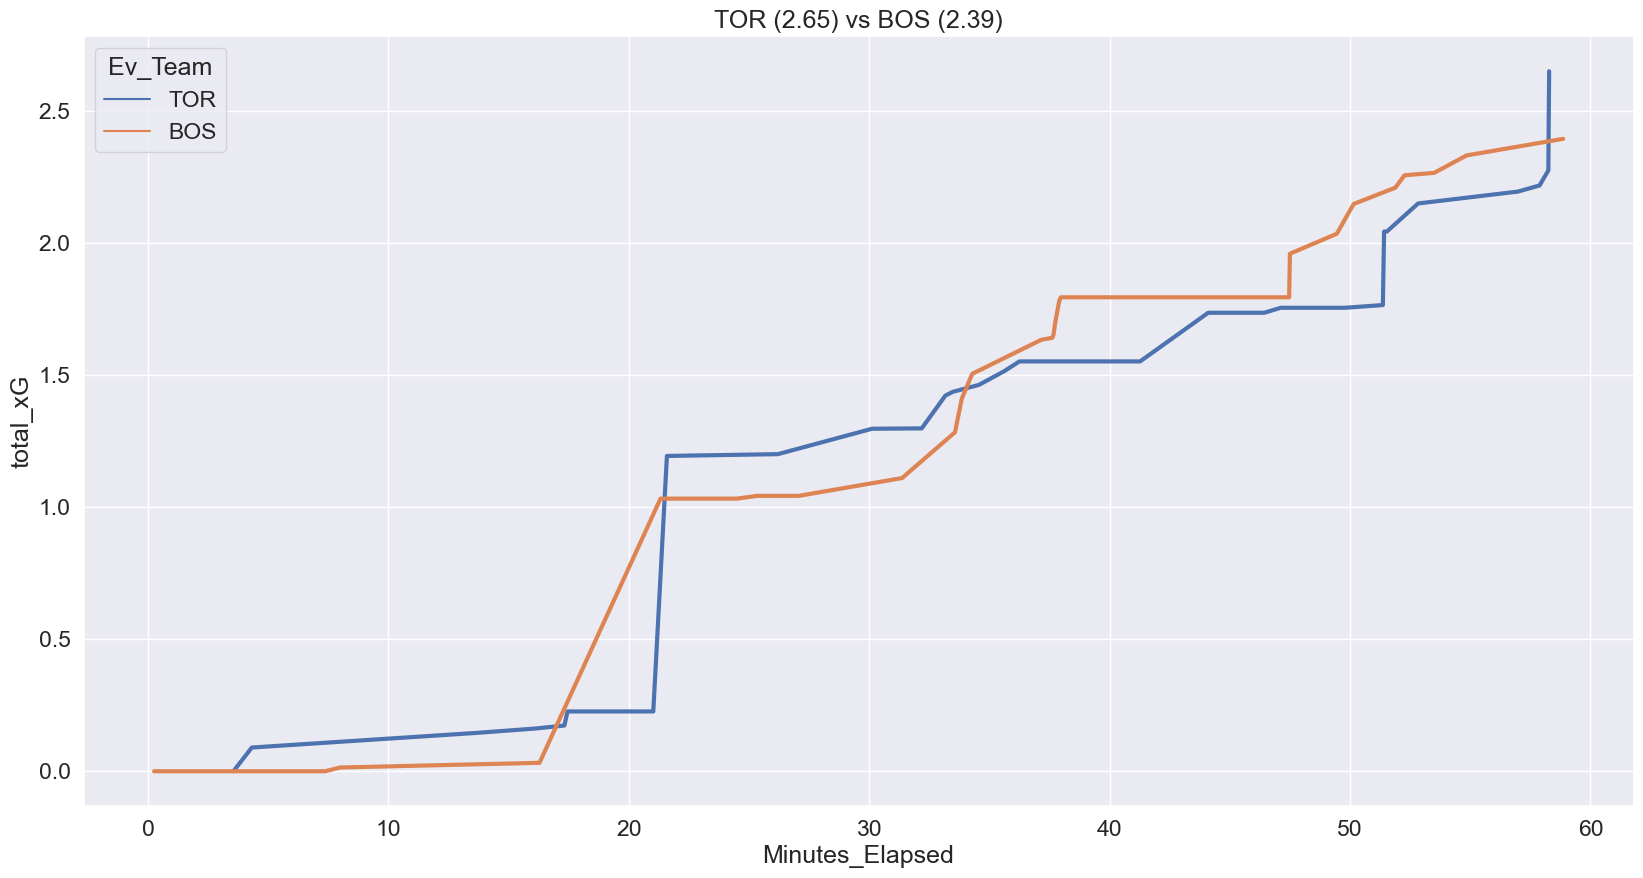

In [11]:
game_id = 30123

val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_1714030348.csv")


combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score = single_game_evaluation(original_input, game_id, "5x5")

# print combined rows to csv
combined_rows.to_csv("combined_rows.csv")

# plot the total_xG of the home team
float_formatter = "{:.2f}".format
sns.set_theme(rc={'figure.figsize':(20,10)})
sns.set_theme(style="darkgrid", font='Arial', font_scale=1.5, color_codes=True, rc=None)
# set title to [home_team] vs [away_team]
plt.title(f"{home_team} ({float_formatter(total_home_xG)}) vs {away_team} ({float_formatter(total_away_xG)})")
sns.lineplot(data=combined_rows, x="Minutes_Elapsed", y="total_xG", hue="Ev_Team", linewidth = 3)


# Full Season Rolling Evaluation

Rough idea is as follows:

- For the first 20 games of each team's season, just tally the team's XG% (all situations)
- From then on out (assuming both teams have 20 games), take the avg xG% of each teams last 20 games, then compare/normalize to 100%. Figure out who the winner was, and mark that as a correct prediction, or a failure.

In [157]:
# read in nhl_pbp_20232024.csv
val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20172018.csv")







C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\2818863966.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


(119717, 78)


In [172]:
# split original_input into multiple dataframes based off of game_id
game_ids = original_input["Game_Id"].unique()
# remove all instances of game_ids that start with 3
game_ids = [x for x in game_ids if str(x)[0] != "3"]

nhl_teams = {}

results = []
predictions = []
predictions_rounded = []

for game_id in game_ids:
    # print(f"Game ID: {game_id}")
    combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score = single_game_evaluation(original_input, game_id, "any")

    # add the total_xG of the home team and away team to nhl_teams
    if home_team not in nhl_teams:
        nhl_teams[home_team] = {"xG_percent": [], "total_games": 0}
    if away_team not in nhl_teams:
        nhl_teams[away_team] = {"xG_percent": [], "total_games": 0}

    # if both teams have more than 20 games played, create a prediciton for the game
    if nhl_teams[home_team]["total_games"] >= 20 and nhl_teams[away_team]["total_games"] >= 20:
        # get the average of last 20 games for home_team and away_team
        # home_xG_percent_avg = np.mean(nhl_teams[home_team]["xG_percent"])
        # away_xG_percent_avg = np.mean(nhl_teams[away_team]["xG_percent"])

        # home_xG_percent_avg = home_xG_percent_avg / (home_xG_percent_avg + away_xG_percent_avg)
        # away_xG_percent_avg = away_xG_percent_avg / (home_xG_percent_avg + away_xG_percent_avg)

        # # Apply linear decay to each home_team's xg_percent game by game
        decay_rate = 0.01  # Adjust the decay rate as desired

        # Calculate the decayed xg_percent for each game
        home_decayed_xg_percent = np.zeros_like(nhl_teams[home_team]["xG_percent"])
        len_home_games = len(nhl_teams[home_team]["xG_percent"])
        for i in range(len_home_games):
            home_decayed_xg_percent[i] = nhl_teams[home_team]["xG_percent"][(len_home_games - i -1 )] * (1 - (decay_rate * i))

        away_decayed_xg_percent = np.zeros_like(nhl_teams[away_team]["xG_percent"])
        len_away_games = len(nhl_teams[away_team]["xG_percent"])
        for i in range(len_away_games):
            away_decayed_xg_percent[i] = nhl_teams[away_team]["xG_percent"][(len_away_games - i - 1)] * (1 - (decay_rate * i))

        home_xG_percent_sum = np.sum(home_decayed_xg_percent)
        away_xG_percent_sum = np.sum(away_decayed_xg_percent)
        
        home_xG_percent_avg = home_xG_percent_sum / (home_xG_percent_sum + away_xG_percent_sum)
        away_xG_percent_avg = away_xG_percent_sum / (home_xG_percent_sum + away_xG_percent_sum)

        results.append(home_score > away_score)
        if (home_score == away_score):
            print("OH LOOK A SHOOTOUT WHOOPS")
        predictions.append(home_xG_percent_avg)
        predictions_rounded.append(home_xG_percent_avg.round())

        # if home_xG_percent_avg > away_xG_percent_avg:
        #     print(f"{home_xG_percent_avg}")
        # else:
        #     print(f"{away_xG_percent_avg}")

    home_xG_percent = total_home_xG / (total_home_xG + total_away_xG)
    away_xG_percent = total_away_xG / (total_home_xG + total_away_xG)

    nhl_teams[home_team]["xG_percent"].append(home_xG_percent)
    nhl_teams[away_team]["xG_percent"].append(away_xG_percent)
    nhl_teams[home_team]["total_games"] += 1
    nhl_teams[away_team]["total_games"] += 1

OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SHOOTOUT WHOOPS
OH LOOK A SH

In [159]:
    
    
# get the accuracy of the model
results_tensor = torch.tensor(results, dtype=torch.float32)
predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
predictions_rounded_tensor = torch.tensor(predictions_rounded, dtype=torch.float32)

accuracy = (predictions_rounded_tensor == results_tensor).float().mean()

# calculate log loss of predicitons
log_loss = nn.BCELoss()
log_loss_results = log_loss(predictions_tensor, results_tensor)

print(f"Accuracy {accuracy}")
print(f"log loss {log_loss_results}")


Accuracy 0.5204616785049438
log loss 0.6909236907958984


In [169]:
def get_season_accuracy(original_input):
    # split original_input into multiple dataframes based off of game_id
    game_ids = original_input["Game_Id"].unique()
    # remove all instances of game_ids that start with 3
    game_ids = [x for x in game_ids if str(x)[0] != "3"]

    nhl_teams = {}

    results = []
    predictions = []
    predictions_rounded = []

    for game_id in game_ids:
        # print(f"Game ID: {game_id}")
        combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score = single_game_evaluation(original_input, game_id, "any")

        # add the total_xG of the home team and away team to nhl_teams
        if home_team not in nhl_teams:
            nhl_teams[home_team] = {"xG_percent": [], "total_games": 0}
        if away_team not in nhl_teams:
            nhl_teams[away_team] = {"xG_percent": [], "total_games": 0}

        # if both teams have more than 20 games played, create a prediciton for the game
        if nhl_teams[home_team]["total_games"] >= 20 and nhl_teams[away_team]["total_games"] >= 20:
            # get the average of last 20 games for home_team and away_team
            # home_xG_percent_avg = np.mean(nhl_teams[home_team]["xG_percent"])
            # away_xG_percent_avg = np.mean(nhl_teams[away_team]["xG_percent"])

            # home_xG_percent_avg = home_xG_percent_avg / (home_xG_percent_avg + away_xG_percent_avg)
            # away_xG_percent_avg = away_xG_percent_avg / (home_xG_percent_avg + away_xG_percent_avg)

            # # Apply linear decay to each home_team's xg_percent game by game
            decay_rate = 0.01  # Adjust the decay rate as desired

            # Calculate the decayed xg_percent for each game
            home_decayed_xg_percent = np.zeros_like(nhl_teams[home_team]["xG_percent"])
            len_home_games = len(nhl_teams[home_team]["xG_percent"])
            for i in range(len_home_games):
                home_decayed_xg_percent[i] = nhl_teams[home_team]["xG_percent"][(len_home_games - i -1 )] * (1 - (decay_rate * i))

            away_decayed_xg_percent = np.zeros_like(nhl_teams[away_team]["xG_percent"])
            len_away_games = len(nhl_teams[away_team]["xG_percent"])
            for i in range(len_away_games):
                away_decayed_xg_percent[i] = nhl_teams[away_team]["xG_percent"][(len_away_games - i - 1)] * (1 - (decay_rate * i))

            home_xG_percent_sum = np.sum(home_decayed_xg_percent)
            away_xG_percent_sum = np.sum(away_decayed_xg_percent)
            
            home_xG_percent_avg = home_xG_percent_sum / (home_xG_percent_sum + away_xG_percent_sum)
            away_xG_percent_avg = away_xG_percent_sum / (home_xG_percent_sum + away_xG_percent_sum)

            results.append(home_score > away_score)
            predictions.append(home_xG_percent_avg)
            predictions_rounded.append(home_xG_percent_avg.round())

            # if home_xG_percent_avg > away_xG_percent_avg:
            #     print(f"{home_xG_percent_avg}")
            # else:
            #     print(f"{away_xG_percent_avg}")

        home_xG_percent = total_home_xG / (total_home_xG + total_away_xG)
        away_xG_percent = total_away_xG / (total_home_xG + total_away_xG)

        nhl_teams[home_team]["xG_percent"].append(home_xG_percent)
        nhl_teams[away_team]["xG_percent"].append(away_xG_percent)
        nhl_teams[home_team]["total_games"] += 1
        nhl_teams[away_team]["total_games"] += 1

    # get the accuracy of the model
    results_tensor = torch.tensor(results, dtype=torch.float32)
    predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
    predictions_rounded_tensor = torch.tensor(predictions_rounded, dtype=torch.float32)

    accuracy = (predictions_rounded_tensor == results_tensor).float().mean()

    # calculate log loss of predicitons
    log_loss = nn.BCELoss()
    log_loss_results = log_loss(predictions_tensor, results_tensor)

    # print(f"Accuracy {accuracy}")
    # print(f"log loss {log_loss_results}")

    return accuracy, log_loss_results

In [173]:
seasons = ["nhl_pbp_20172018", "nhl_pbp_20182019", "nhl_pbp_20192020", "nhl_pbp_20202021", "nhl_pbp_20212022", "nhl_pbp_20222023", "nhl_pbp_20232024"]

for season in seasons:
    val_input_data, val_result_data, original_input = create_input_data_from_csv(f"C:\\Users\\JoshG\\hockey_scraper_data\\csvs\\{season}.csv")
    accruacy, results = get_season_accuracy(original_input)
    print(f"Season: {season} Accuracy: {accruacy} Log Loss: {results}")

# # read in nhl_pbp_20232024.csv
# val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20232024.csv")

# get_season_accuracy(original_input)

C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\2818863966.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


(119717, 78)
[False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, True, True, False, True, False, False, True, False, False, True, False, False, False, True, True, False, False, True, False, False, False, False, False, True, True, True, True, False, True, False, False, False, False, True, False, False, False, True, True, False, False, False, False, False, True, False, True, False, False, False, True, True, False, False, True, False, False, False, True, True, True, True, True, False, False, True, False, False, False, True, False, False, True, False, True, False, False, False, False, True, True, False, False, True, False, True, False, True, False, True, True, False, False, True, True, True, False, True, False, False, True, False, False, False, False, True, False, False, False, True, False, True, False, True, True, False, True, True, False, False, True, False, False, False, True, True, True, True, T

C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\2818863966.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


(117757, 78)
[True, True, True, True, True, False, True, True, True, False, True, True, False, True, False, False, True, True, False, True, True, False, True, True, True, False, True, False, True, False, False, False, True, True, False, False, True, False, False, True, True, True, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, True, False, True, True, True, False, True, True, False, False, True, False, False, True, True, False, False, True, False, False, True, False, False, True, True, True, False, False, False, False, False, True, False, True, True, True, False, True, False, False, True, False, False, True, False, False, True, True, False, False, False, True, False, True, True, False, True, True, False, True, False, True, False, False, True, True, False, False, True, False, False, False, True, False, True, False, False, False, True, True, False, True, True, True, True, False, False, False, True, True, Tr

C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\2818863966.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


(104313, 78)
[False, True, False, False, True, True, True, False, True, False, False, True, False, True, False, False, True, False, False, True, True, False, True, True, False, False, True, True, False, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, True, False, True, False, True, False, True, True, False, False, False, True, False, False, False, False, True, True, True, False, False, False, True, True, False, False, False, True, True, False, True, False, True, False, False, True, False, False, False, False, False, False, False, True, True, True, True, False, True, False, True, False, True, False, True, False, False, False, True, True, True, False, False, True, False, False, True, True, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, True, True, False, True, False, False, False, True, True, True, False, True, True, True, True, True, False, False, False, False, False, Tru

C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\2818863966.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


(78581, 78)
[False, False, True, False, False, False, False, True, True, False, True, False, False, False, True, True, False, True, False, False, False, True, True, False, False, False, True, True, True, False, False, False, False, True, True, False, True, True, True, False, False, True, False, True, False, True, False, False, True, False, True, False, True, False, False, False, True, False, False, False, False, False, False, False, True, True, True, False, False, False, True, False, True, False, True, False, False, True, False, True, False, True, True, True, False, False, False, False, False, False, True, True, False, True, False, True, False, True, False, False, False, True, True, False, False, False, True, True, False, False, True, True, True, True, False, True, True, False, True, False, True, False, False, True, True, True, False, False, False, True, False, True, True, True, False, True, False, False, False, False, False, True, True, True, False, True, False, False, False, True, Fa

C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\2818863966.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


(121546, 78)
[False, True, False, False, False, False, False, False, False, False, False, False, True, False, True, False, True, True, True, True, False, False, True, True, False, True, True, False, False, True, False, False, False, True, False, False, True, True, False, False, True, True, False, True, False, False, False, True, True, False, True, False, False, False, False, False, False, False, False, True, True, False, False, True, False, False, False, False, True, False, False, False, True, False, False, False, False, True, False, False, False, True, False, False, True, True, True, False, False, False, False, True, True, False, False, True, True, True, False, False, False, True, True, True, False, False, True, False, False, False, False, False, True, False, True, False, False, True, True, True, False, True, False, False, False, True, False, False, False, False, True, True, False, False, False, True, False, False, True, False, False, False, False, False, True, True, True, False, Fals

KeyboardInterrupt: 

: 

In [148]:
# for each team in nhl_teams, get the avg xG% over the last 20 games played and sort
team_xG_percent = {}
for team in nhl_teams:
    if nhl_teams[team]["total_games"] >= 20:
        team_xG_percent[team] = np.mean(nhl_teams[team]["xG_percent"][-20:])
    else:
        team_xG_percent[team] = 0

sorted_team_xG_percent = dict(sorted(team_xG_percent.items(), key=lambda item: item[1], reverse=True))

for key, value in sorted_team_xG_percent.items():
    print(f'{key}:  {value}')


nhl_team_strength = {}

for team in nhl_teams:
    decayed_xg_percent = np.zeros_like(nhl_teams[team]["xG_percent"])
    len_games_games = len(nhl_teams[team]["xG_percent"])
    for i in range(len_games_games):
        decayed_xg_percent[i] = nhl_teams[team]["xG_percent"][(len_games_games - i - 1)] * (1 - (decay_rate * i))

    nhl_team_strength[team] = np.sum(decayed_xg_percent)

sorted_team_xG_total = dict(sorted(nhl_team_strength.items(), key=lambda item: item[1], reverse=True))

print("\n\n Team Strength")

for key, value in sorted_team_xG_total.items():
    print(f'{key}:  {value}')



DAL:  0.6298092603683472
EDM:  0.6015709638595581
CAR:  0.6011729836463928
FLA:  0.5995128750801086
MIN:  0.5986486077308655
VAN:  0.5929917097091675
PHI:  0.5700408816337585
TOR:  0.5678231120109558
COL:  0.5558242201805115
VGK:  0.5427173972129822
NYR:  0.5264555215835571
WPG:  0.5192416310310364
NSH:  0.517433226108551
PIT:  0.5012862682342529
SEA:  0.49852555990219116
T.B:  0.4978720247745514
NYI:  0.4922565817832947
STL:  0.4902094304561615
OTT:  0.4823831617832184
BOS:  0.476470947265625
CGY:  0.46763935685157776
DET:  0.46017760038375854
L.A:  0.45457011461257935
ANA:  0.45454007387161255
S.J:  0.4512979984283447
N.J:  0.4457371234893799
WSH:  0.4367344379425049
BUF:  0.435657799243927
ARI:  0.42983952164649963
CHI:  0.39450573921203613
MTL:  0.39344725012779236
CBJ:  0.3741791546344757


 Team Strength
FLA:  28.745014190673828
CAR:  28.289438247680664
EDM:  28.149267196655273
DAL:  27.053220748901367
TOR:  26.84708595275879
COL:  26.34925651550293
MIN:  26.327245712280273
PHI: 

In [150]:

# convert results_tensor to 1/0
# results = [int(x) for x in results]

predictions2 = predictions
results2 = results

print(results2)
print(predictions2)

# for cases where predictions < 0.5, set the value to 1 - prediction and swap results to the opposite
for i in range(len(predictions2)):
    if predictions2[i] < 0.5:
        predictions2[i] = 1 - predictions2[i]
        if results2[i] == False:
            results2[i] = True
        else:
            results2[i] = False

# find all predictions where the prediction is between 0.50 and 0.51 and calculate the accuracy against results

print(results2)
print(predictions2)

results_tensor = torch.tensor(results2)
predictions_tensor = torch.tensor(predictions2)
predictions_rounded = [int(x) for x in predictions2]

x = [0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61]

for i in x:
    indices = torch.where((predictions_tensor >= i) & (predictions_tensor <= i + 0.01))
    filtered_predictions_tensor = predictions_tensor[indices]
    filtered_results_tensor = results_tensor[indices]
    filtered_predictions_rounded_tensor = predictions_rounded_tensor[indices]

    # print(f"Filtered_predictions: {filtered_predictions_tensor}")
    # print(f"Filtered_results: {filtered_results_tensor}")

    # convert filtered_results_tensor from 1/0 to True/False
    filtered_results_tensor = filtered_results_tensor.bool()

    accuracy_tensor = (filtered_results_tensor).float().mean()
    # get length of filtered_results_tensor
    length = len(filtered_results_tensor)
    

    print(f"{i}, {accuracy_tensor}, {len(filtered_results_tensor)}")

    # print(f"Filtered Accuracy {i}: {filtered_predictions_tensor.item()}")


# # Find the indices of predictions between 0.50 and 0.51
# indices = torch.where((predictions_tensor >= 0.50) & (predictions_tensor <= 0.51))

# # Get the corresponding predictions and results_tensor
# filtered_predictions_tensor = predictions_tensor[indices]
# filtered_results_tensor = results_tensor[indices]
# # make a rounded predicitons tensor

# predictions_rounded_tensor = torch.tensor(predictions_rounded, dtype=torch.float32)
# filtered_predictions_rounded_tensor = predictions_rounded_tensor[indices]

# # print(filtered_results_tensor)
# # print(filtered_predictions_tensor)


# # Calculate the predictions_tensor against the results_tensor
# filtered_predictions_tensor = torch.mean((filtered_predictions_rounded_tensor == filtered_results_tensor).float())

# # Print the filtered predictions_tensor
# print("Filtered Accuracy:", filtered_predictions_tensor.item())





[False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, True, False, False, False, True, False, False, False, False, False, True, False, False, False, False, True, True, True, True, False, True, True, True, True, True, False, False, True, False, False, True, False, True, False, True, True, False, True, False, True, True, True, False, True, False, False, True, False, True, False, False, True, False, False, True, False, True, True, True, True, False, True, True, False, False, False, True, False, True, True, False, True, True, True, True, False, False, False, False, True, True, False, False, True, True, True, True, True, True, False, False, False, False, False, True, True, False, False, False, False, True, True, True, True, True, False, True, False, True, True, True, False, True, False, True, True, True, True, False, True, True, False, False, True, False, True, False, False, True, True, False, True, True, True, False, False, False, 

C:\Users\JoshG\AppData\Local\Temp\ipykernel_36824\581085923.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  results_tensor = torch.tensor(results2)
